# The data block API

data block API를 활용하면 lets you customize the creation of a DataBunch by isolating the underlying parts of that proces in seperate blocks.

1. Where the inputs and how to create them? 
2. How to split the data into a training and validation sets?
3. How to label the inputs?
4. What transforms to apply?
5. How to add a test set?
6. How to wrap in dataloaders and create the DataBunch?

> DataBunch는 collection of dataloaders(train, validation, test)

In [1]:
import fastai.vision as fcv

- fastai의 간단한 파일 구조를 살펴보자.

- `/root/.fastai`가 기본 구조 $\longrightarrow$ 이거 커스텀 가능?
- `config.yml`을 살펴보면, 크게 data_path와 model_path로 구분함.

In [2]:
!ls /root/.fastai

config.yml  data


In [3]:
!cat /root/.fastai/config.yml

data_archive_path: /root/.fastai/data
data_path: /root/.fastai/data
model_path: /root/.fastai/models


## MNIST

- data 아래에 task와 관련된 경로 생성.

In [4]:
## download and path
path = fcv.untar_data(fcv.URLs.MNIST_TINY)
path

PosixPath('/root/.fastai/data/mnist_tiny')

- data 안에 train/valid/test 셋만 나눔.
- MNIST 데이터 구조는 ImageNet 데이터셋 구조로 이루어짐. (폴더에 label이 있음.)

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_tiny/models'),
 PosixPath('/root/.fastai/data/mnist_tiny/train'),
 PosixPath('/root/.fastai/data/mnist_tiny/valid'),
 PosixPath('/root/.fastai/data/mnist_tiny/test')]

In [6]:
(path / 'train').ls()

[PosixPath('/root/.fastai/data/mnist_tiny/train/7'),
 PosixPath('/root/.fastai/data/mnist_tiny/train/3')]

In [7]:
(path / 'valid').ls()

[PosixPath('/root/.fastai/data/mnist_tiny/valid/7'),
 PosixPath('/root/.fastai/data/mnist_tiny/valid/3')]

In [8]:
(path / 'test').ls()[:5]

[PosixPath('/root/.fastai/data/mnist_tiny/test/2032.png'),
 PosixPath('/root/.fastai/data/mnist_tiny/test/3515.png'),
 PosixPath('/root/.fastai/data/mnist_tiny/test/1883.png'),
 PosixPath('/root/.fastai/data/mnist_tiny/test/500.png'),
 PosixPath('/root/.fastai/data/mnist_tiny/test/1503.png')]

In [9]:
(path / 'model').ls() # 이 새끼 뭐하지?

FileNotFoundError: [Errno 2] No such file or directory: '/root/.fastai/data/mnist_tiny/model'

### DataBunch
- dataloader들의 뭉치임.
- 예제 데이터의 경우 short_cut으로 databunch를 구성할 수 있음.

In [11]:
tfms = fcv.get_transforms(do_flip=False)
data = fcv.ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64) # path는 프로젝트 경로, ds_tfms은 적용할 transform, size는 배치사이즈.

### data block API
- DataBunch를 커스텀 가능하게 구성할 수 있음.
- 위의 6가지 기능을 독립적으로 구현 가능.

In [12]:
data = (fcv.ImageList.from_folder(path) # 1. Where to find the data? -> in path and its subfolders
        .split_by_folder()              # 2. How to split in train/valid? -> use the folders
        .label_from_folder()            # 3. How to label? -> depending on the folder of the filenames
        .add_test_folder()              # 4. Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       # 5. Data augmentation? -> use tfms with a size of 64
        .databunch())                   # 6. Finally? -> use the defaults for conversion to ImageDataBunch

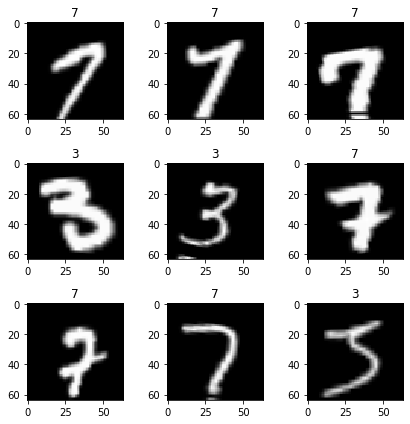

In [13]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

## Planet Data

In [14]:
planet = fcv.untar_data(fcv.URLs.PLANET_TINY)

- train set과 label만 있음.

In [15]:
planet.ls()

[PosixPath('/root/.fastai/data/planet_tiny/labels.csv'),
 PosixPath('/root/.fastai/data/planet_tiny/train')]

In [16]:
(planet / 'train').ls()[:4]

[PosixPath('/root/.fastai/data/planet_tiny/train/train_36622.jpg'),
 PosixPath('/root/.fastai/data/planet_tiny/train/train_26158.jpg'),
 PosixPath('/root/.fastai/data/planet_tiny/train/train_9638.jpg'),
 PosixPath('/root/.fastai/data/planet_tiny/train/train_28824.jpg')]

- multi_label classification 문제임.

In [17]:
import pandas as pd
pd.read_csv(planet / "labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [18]:
planet_tfms = fcv.get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [19]:
data = (fcv.ImageList.from_csv(path=planet, csv_name='labels.csv', folder='train', suffix='.jpg') 
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

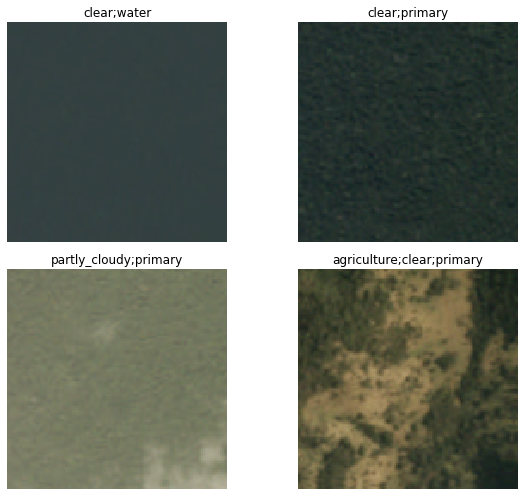

In [20]:
data.show_batch(rows=2, figsize=(9,7))

## Camvid

data block API를 잘 사용하면, databunch를 커스텀하기 좋음. $\Longrightarrow$ Segmentation

In [9]:
camvid = fcv.untar_data(fcv.URLs.CAMVID_TINY)

In [10]:
camvid.ls()

[PosixPath('/root/.fastai/data/camvid_tiny/images'),
 PosixPath('/root/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels')]

In [11]:
(camvid / 'images').ls()[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_08057.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0006R0_f03330.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0001TP_006750.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_07290.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_06870.png')]

In [12]:
## mask?
(camvid / 'labels').ls()[:5]

[PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_06990_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_008160_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01440_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f03660_P.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0001TP_008760_P.png')]

In [13]:
## class
import numpy as np
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
path_lbl = camvid/'labels'
path_img = camvid/'images'

In [15]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [21]:
path_lbl

PosixPath('/root/.fastai/data/camvid_tiny/labels')

In [23]:
path_img

PosixPath('/root/.fastai/data/camvid_tiny/images')

In [41]:
data = (fcv.SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(fcv.get_transforms(), tfm_y=True, size=128)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch())
        #Finally -> use the defaults for conversion to databunch

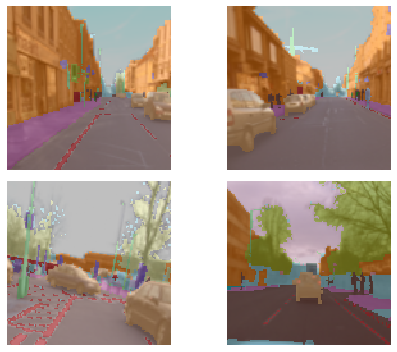

In [42]:
data.show_batch(rows=2, figsize=(7,5))

## Coco Dataset